# **Red neuronal convolucional para el diagnóstico de nódulos tiroideos según la clasificación EU-TIRADS**

## Por Alejandro Martínez Hernández

### Notebook 4/4

# **Creación de modelos**

Para la siguiente parte se crearan los siguientes modelos de clasificación simple:
- model1
- model2

In [3]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, VGG19, MobileNetV3Small, MobileNetV3Large, Xception, ResNet50, ResNet101, DenseNet121
from sklearn.model_selection import GroupShuffleSplit
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam, SGD
import matplotlib.pyplot as plt

# Función para cargar las imágenes y las etiquetas desde las carpetas
def load_images(base_dir, input_size=(224, 224)):
    categories = ['high', 'low']
    data = []
    labels = []
    groups = []

    for category in categories:
        path = os.path.join(base_dir, category)
        class_num = categories.index(category)
        for img in os.listdir(path):
            img_path = os.path.join(path, img)
            image = cv2.imread(img_path)
            if image is not None:
                image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                image = cv2.resize(image, input_size)
                image = np.stack((image,) * 3, axis=-1)
                data.append(image)
                labels.append(class_num)
                patient_id = img.split('_')[0]
                groups.append(patient_id)

    return np.array(data), np.array(labels), np.array(groups)

# Configurar generadores de imágenes
def setup_image_generators(X_train, X_val, y_train, y_val):
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=5,
        zoom_range=[0.2, 1.2],
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='constant'
    )

    validation_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow(X_train, y_train)
    val_generator = validation_datagen.flow(X_val, y_val)

    return train_generator, val_generator

# Crear el modelo
def create_model(base_model_name, optimizer_name, input_shape=(224, 224, 3), learning_rate=0.01):
    model_dict = {
        'VGG16': VGG16,
        'VGG19': VGG19,
        'MobileNetV3Small': MobileNetV3Small,
        'MobileNetV3Large': MobileNetV3Large,
        'Xception': Xception,
        'ResNet50': ResNet50,
        'ResNet101': ResNet101,
        'DenseNet': DenseNet121
    }

    optimizer_dict = {
        'Adam': Adam(learning_rate=learning_rate),
        'SGD': SGD(learning_rate=learning_rate)
    }

    base_model = model_dict[base_model_name](include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=optimizer_dict[optimizer_name], loss='binary_crossentropy', metrics=['accuracy'])
    return model

def train_model(base_model_name, optimizer_name, base_directory='db_unal/organized/images/cropped', input_size=(224, 224), learning_rate=0.01, epochs=1000):
    # Cargar las imágenes
    X, y, groups = load_images(base_directory, input_size)

    # Dividir los datos en conjuntos de entrenamiento y validación
    gss = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state=42)
    train_idx, val_idx = next(gss.split(X, y, groups=groups))

    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    # Configurar generadores de imágenes
    train_gen, val_gen = setup_image_generators(X_train, X_val, y_train, y_val)

    # Crear y compilar el modelo
    model = create_model(base_model_name, optimizer_name, input_shape=(input_size[0], input_size[1], 3), learning_rate=learning_rate)

    # Calcular los pesos de clase para manejar datos desbalanceados
    weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
    class_weights = {i: weights[i] for i in range(len(weights))}

    # Configurar los callbacks
    early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=300, verbose=1, mode='min')

    # Entrenar el modelo
    history = model.fit(train_gen, validation_data=val_gen, epochs=epochs, class_weight=class_weights, callbacks=[early_stopping])

    # Evaluar el modelo en el conjunto de validación
    val_loss, val_accuracy = model.evaluate(val_gen)
    print(f'Validation accuracy: {val_accuracy:.4f}')

    # Métricas de desempeño
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(10, 6))
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.ylim(0, 1.0)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.figure(figsize=(10, 6))
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylim(0, 1.0)
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

## **MobileNetV3**

### **Small Version**

#### **Adam Optimizer**

Epoch 1/1000


c:\Users\alema\Desktop\paper\nodulos_tiroideos\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 296ms/step - accuracy: 0.4819 - loss: 0.7534 - val_accuracy: 0.3696 - val_loss: 0.6946
Epoch 2/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 0.5082 - loss: 0.6881 - val_accuracy: 0.4783 - val_loss: 0.8209
Epoch 3/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 0.4678 - loss: 0.8054 - val_accuracy: 0.5217 - val_loss: 0.7717
Epoch 4/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 0.5527 - loss: 0.7466 - val_accuracy: 0.5217 - val_loss: 0.6942
Epoch 5/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 0.5543 - loss: 0.6938 - val_accuracy: 0.4783 - val_loss: 0.7775
Epoch 6/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 0.4745 - loss: 0.7172 - val_accuracy: 0.4783 - val_loss: 0.8031
Epoch 7/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - accuracy: 0.4572 - loss: 0.6843 - val_accuracy: 0.4783 - val_loss: 0.6964
Epoch 8/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.5306 - loss: 0.6860 - val_accuracy: 0.5217 - val_lo

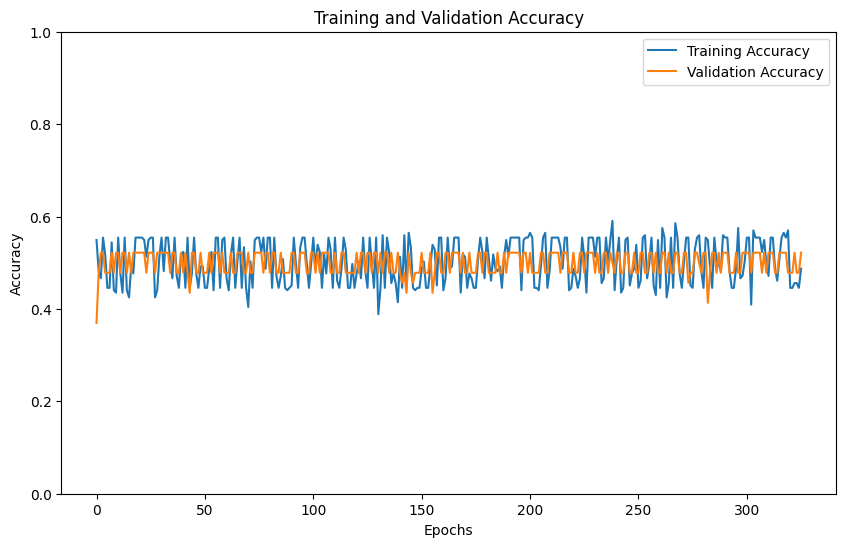

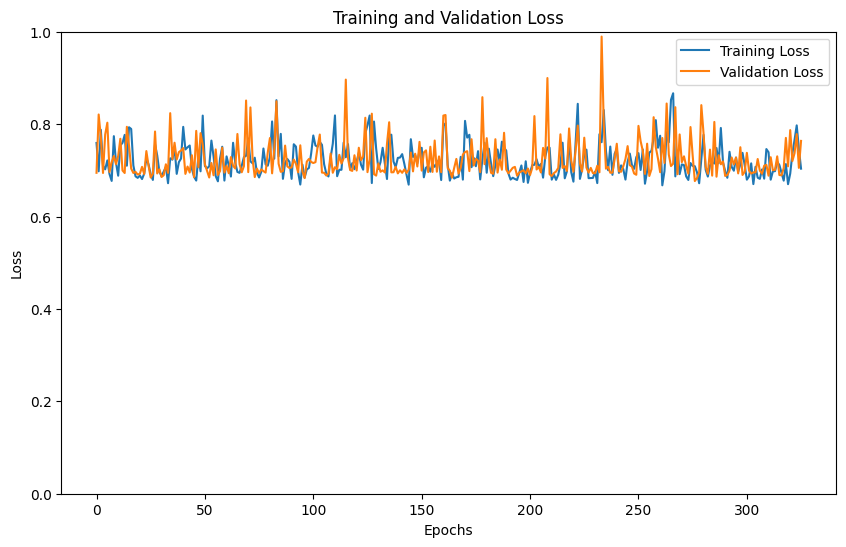

In [4]:
train_model('MobileNetV3Small', 'Adam')

#### **SGD optimizer**

Epoch 1/1000


c:\Users\alema\Desktop\paper\nodulos_tiroideos\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 293ms/step - accuracy: 0.4386 - loss: 0.7314 - val_accuracy: 0.4783 - val_loss: 0.7329
Epoch 2/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 0.4407 - loss: 0.7182 - val_accuracy: 0.5217 - val_loss: 0.6918
Epoch 3/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 0.5343 - loss: 0.7075 - val_accuracy: 0.4783 - val_loss: 0.6943
Epoch 4/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 0.5053 - loss: 0.6927 - val_accuracy: 0.5217 - val_loss: 0.7026
Epoch 5/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - accuracy: 0.3893 - loss: 0.7750 - val_accuracy: 0.4783 - val_loss: 0.6929
Epoch 6/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.4951 - loss: 0.7246 - val_accuracy: 0.4783 - val_loss: 0.6931
Epoch 7/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 0.4881 - loss: 0.7142 - val_accuracy: 0.4783 - val_loss: 0.6977
Epoch 8/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 0.4572 - loss: 0.7069 - val_accuracy: 0.4783 - val_lo

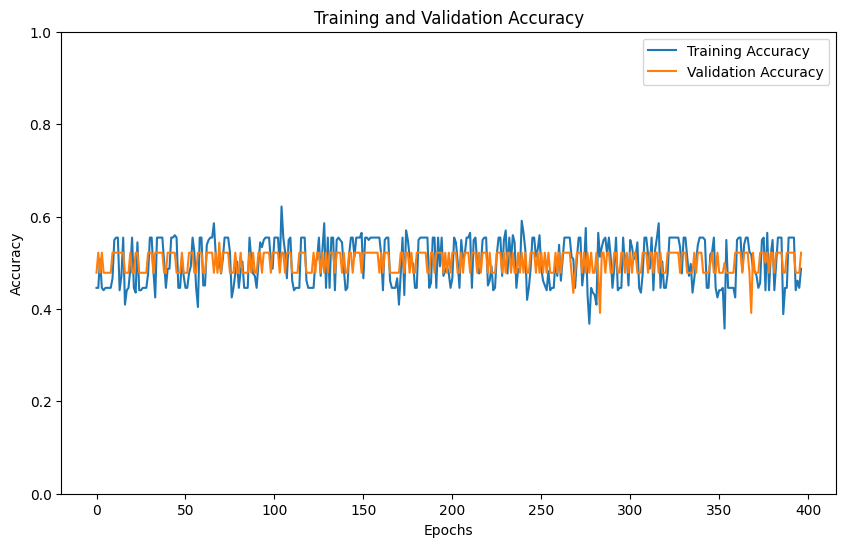

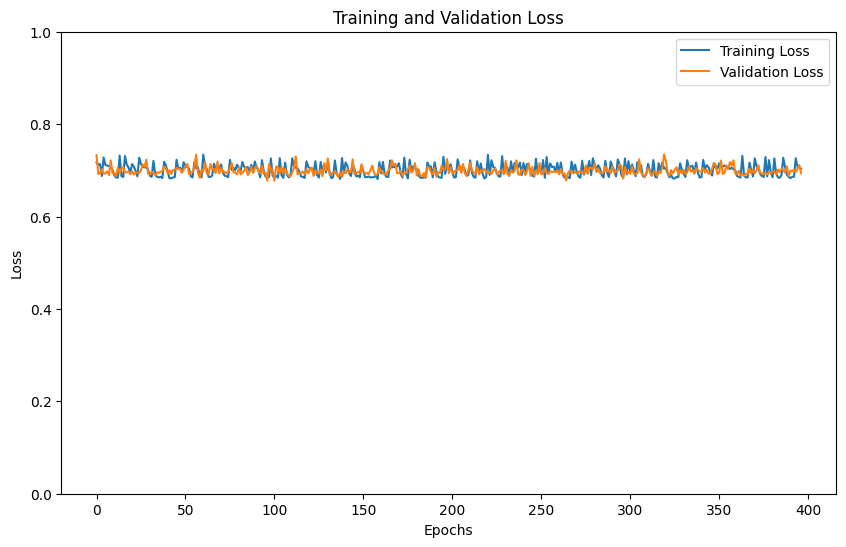

In [5]:
train_model('MobileNetV3Small', 'SGD')

### **Large Version**

#### **Adam Optimizer**

Epoch 1/1000


c:\Users\alema\Desktop\paper\nodulos_tiroideos\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 559ms/step - accuracy: 0.4943 - loss: 0.7222 - val_accuracy: 0.5217 - val_loss: 0.6935
Epoch 2/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 355ms/step - accuracy: 0.5379 - loss: 0.7271 - val_accuracy: 0.4783 - val_loss: 0.7699
Epoch 3/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 347ms/step - accuracy: 0.4705 - loss: 0.7620 - val_accuracy: 0.4783 - val_loss: 0.6922
Epoch 4/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 362ms/step - accuracy: 0.4641 - loss: 0.7701 - val_accuracy: 0.5217 - val_loss: 0.6900
Epoch 5/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 358ms/step - accuracy: 0.5185 - loss: 0.7101 - val_accuracy: 0.4783 - val_loss: 0.7760
Epoch 6/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 359ms/step - accuracy: 0.4571 - loss: 0.7077 - val_accuracy: 0.4783 - val_loss: 0.7311
Epoch 7/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 357ms/step - accuracy: 0.4836 - loss: 0.7449 - val_accuracy: 0.5217 - val_loss: 0.7903
Epoch 8/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 358ms/step - accuracy: 0.5407 - loss: 0.7594 - val_accuracy: 0.5217 - val_lo

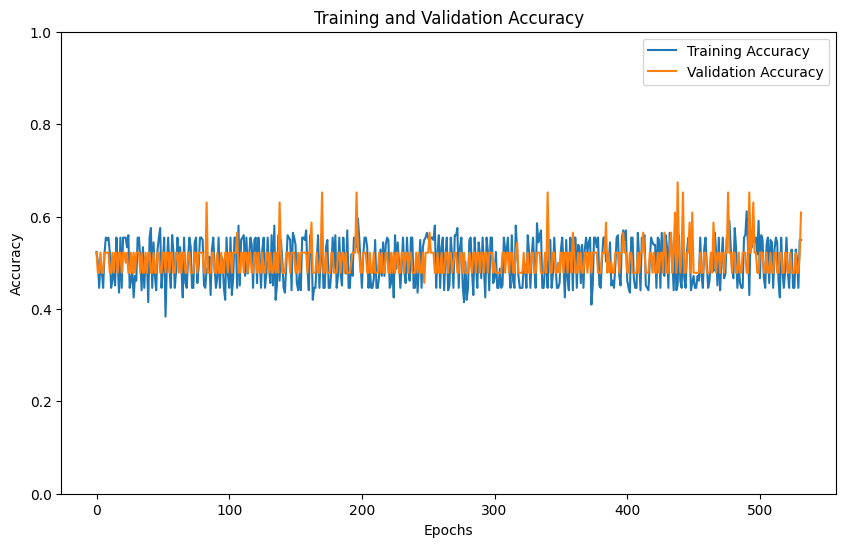

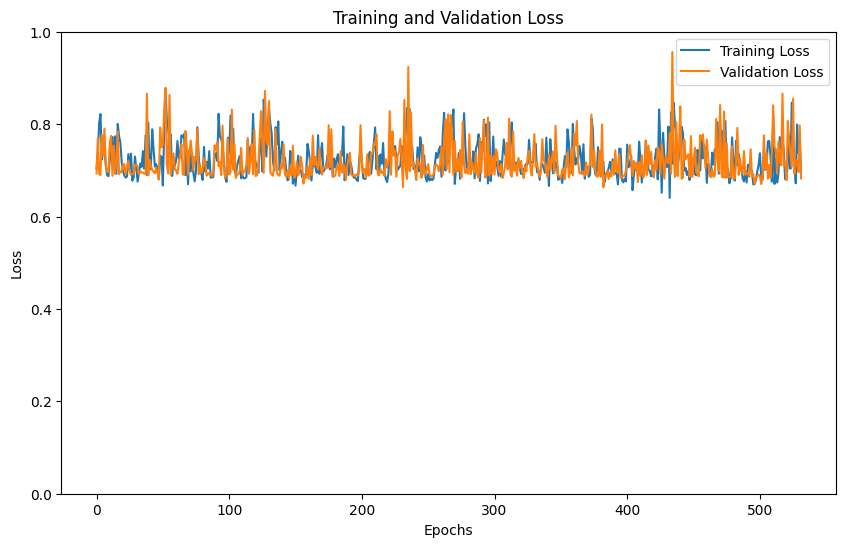

In [6]:
train_model('MobileNetV3Large', 'Adam')

#### **SGD optimizer**

Epoch 1/1000


c:\Users\alema\Desktop\paper\nodulos_tiroideos\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 581ms/step - accuracy: 0.4516 - loss: 0.7696 - val_accuracy: 0.5217 - val_loss: 0.6959
Epoch 2/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 348ms/step - accuracy: 0.5407 - loss: 0.7107 - val_accuracy: 0.5217 - val_loss: 0.6874
Epoch 3/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 349ms/step - accuracy: 0.5274 - loss: 0.6954 - val_accuracy: 0.5217 - val_loss: 0.6939
Epoch 4/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 362ms/step - accuracy: 0.4813 - loss: 0.6959 - val_accuracy: 0.5217 - val_loss: 0.7160
Epoch 5/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 362ms/step - accuracy: 0.5236 - loss: 0.7202 - val_accuracy: 0.4783 - val_loss: 0.9366
Epoch 6/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 360ms/step - accuracy: 0.4637 - loss: 0.7731 - val_accuracy: 0.5217 - val_loss: 0.7275
Epoch 7/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 358ms/step - accuracy: 0.5340 - loss: 0.7017 - val_accuracy: 0.5217 - val_loss: 0.7344
Epoch 8/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 358ms/step - accuracy: 0.5095 - loss: 0.7445 - val_accuracy: 0.4783 - val_lo

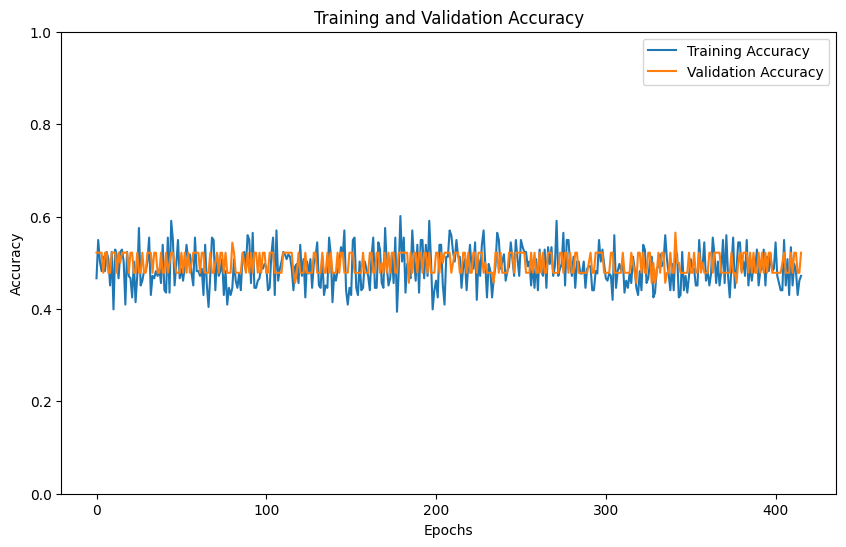

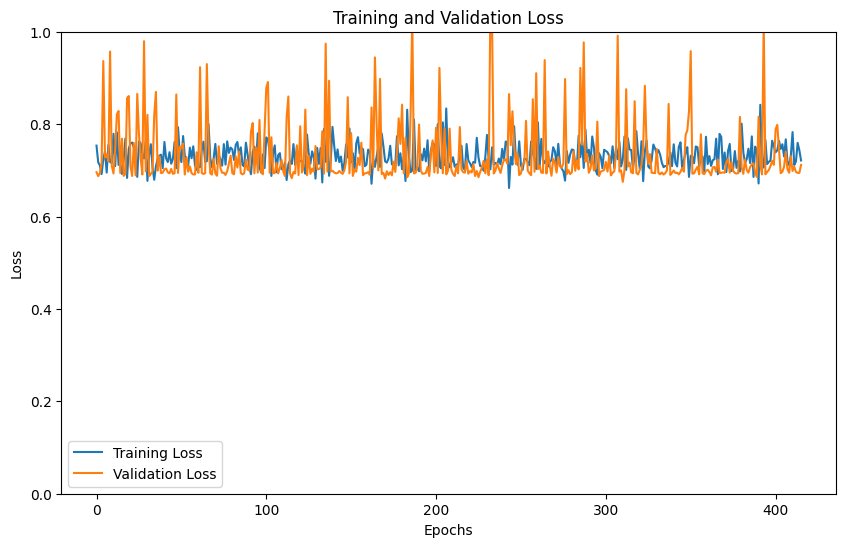

In [7]:
train_model('MobileNetV3Large', 'SGD')

## **ResNet**

### **ResNet50**

#### **Adam Optimizer**

Epoch 1/1000


c:\Users\alema\Desktop\paper\nodulos_tiroideos\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.5172 - loss: 0.7294 - val_accuracy: 0.5217 - val_loss: 0.6945
Epoch 2/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.5250 - loss: 0.7557 - val_accuracy: 0.4783 - val_loss: 0.9179
Epoch 3/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.4583 - loss: 0.7960 - val_accuracy: 0.5217 - val_loss: 0.7254
Epoch 4/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.4911 - loss: 0.8656 - val_accuracy: 0.4783 - val_loss: 0.7125
Epoch 5/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.4695 - loss: 0.7262 - val_accuracy: 0.5217 - val_loss: 0.8038
Epoch 6/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.4791 - loss: 0.8050 - val_accuracy: 0.4783 - val_loss: 0.6997
Epoch 7/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.5058 - loss: 0.7193 - val_accuracy: 0.5217 - val_loss: 0.7153
Epoch 8/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.5242 - loss: 0.7029 - val_accuracy: 0.4783 - val_loss: 0.8303
Epoch

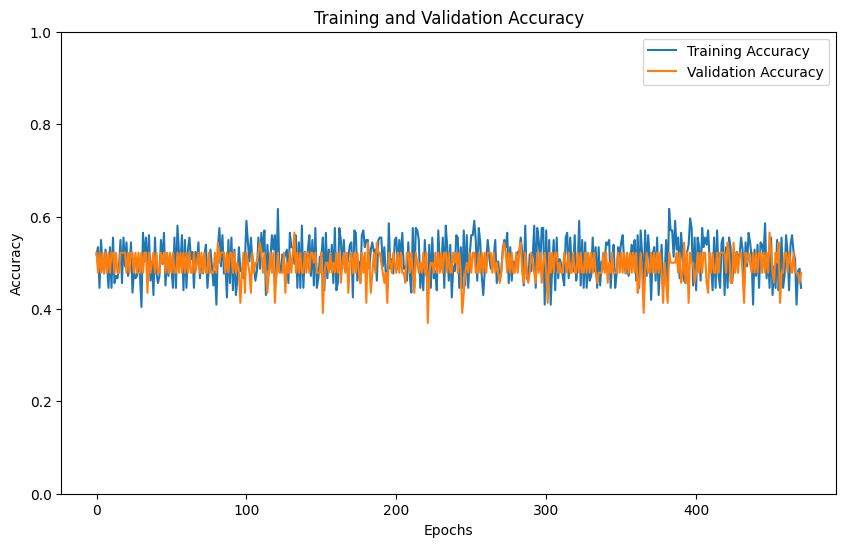

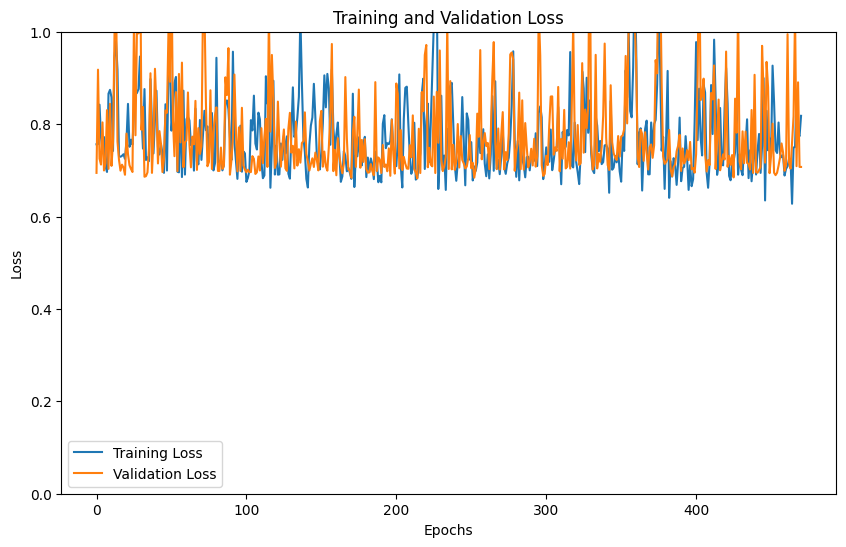

In [8]:
train_model('ResNet50', 'Adam')

#### **SGD Optimizer**

Epoch 1/1000


c:\Users\alema\Desktop\paper\nodulos_tiroideos\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.4693 - loss: 0.8847 - val_accuracy: 0.4783 - val_loss: 0.9276
Epoch 2/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.4277 - loss: 1.2046 - val_accuracy: 0.4783 - val_loss: 0.9533
Epoch 3/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.5614 - loss: 0.7642 - val_accuracy: 0.4783 - val_loss: 0.7141
Epoch 4/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.4725 - loss: 0.8955 - val_accuracy: 0.4783 - val_loss: 0.7025
Epoch 5/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.4010 - loss: 1.0656 - val_accuracy: 0.4783 - val_loss: 1.3953
Epoch 6/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.5598 - loss: 0.8768 - val_accuracy: 0.5217 - val_loss: 0.7755
Epoch 7/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.4588 - loss: 0.8832 - val_accuracy: 0.5217 - val_loss: 0.7649
Epoch 8/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.5462 - loss: 0.8699 - val_accuracy: 0.5217 - val_loss: 0.6865
Epoch

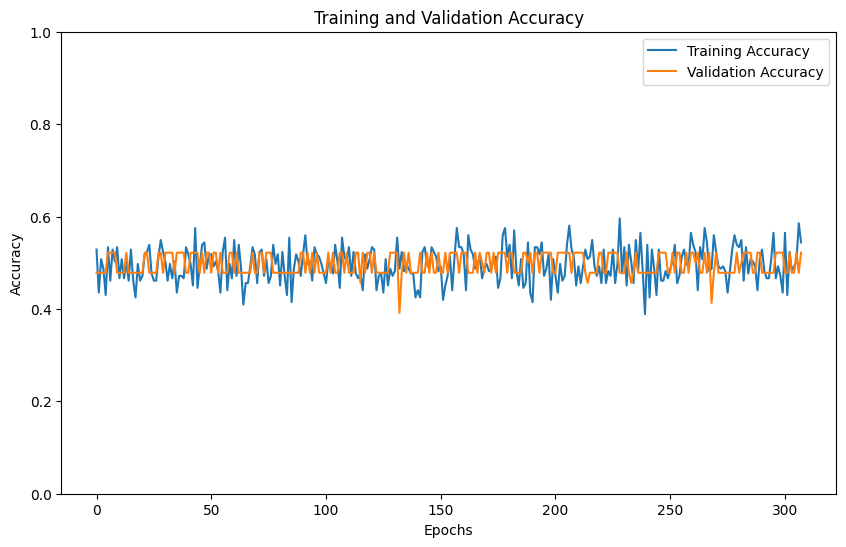

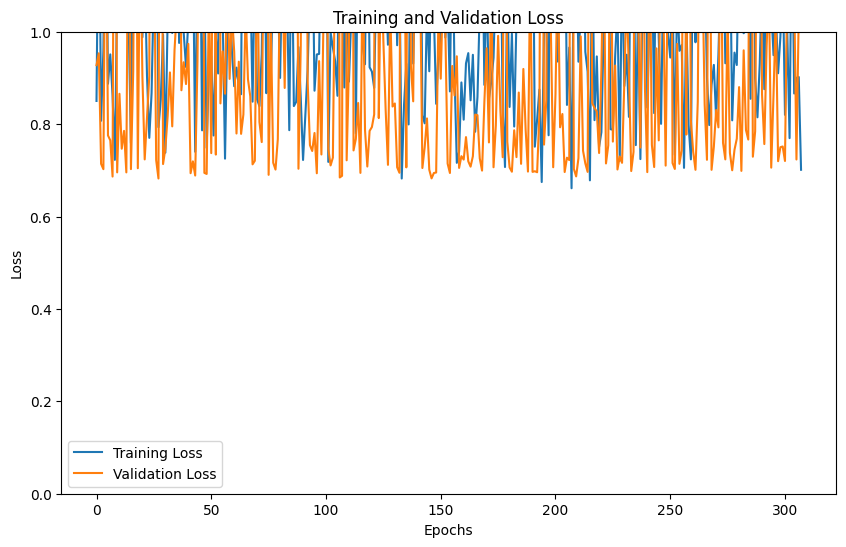

In [9]:
train_model('ResNet50', 'SGD')

### **ResNet101**

#### **Adam Optimizer**

Epoch 1/1000


c:\Users\alema\Desktop\paper\nodulos_tiroideos\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 30s 3s/step - accuracy: 0.6081 - loss: 0.8424 - val_accuracy: 0.4783 - val_loss: 0.9702
Epoch 2/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.3951 - loss: 0.9127 - val_accuracy: 0.5435 - val_loss: 0.6932
Epoch 3/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.4437 - loss: 0.7630 - val_accuracy: 0.5217 - val_loss: 0.6962
Epoch 4/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.6201 - loss: 0.7381 - val_accuracy: 0.5217 - val_loss: 0.6995
Epoch 5/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.4694 - loss: 0.7112 - val_accuracy: 0.4783 - val_loss: 0.8563
Epoch 6/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.5189 - loss: 0.7577 - val_accuracy: 0.5217 - val_loss: 0.9562
Epoch 7/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.5551 - loss: 0.8897 - val_accuracy: 0.4783 - val_loss: 0.7233
Epoch 8/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.5704 - loss: 0.7130 - val_accuracy: 0.5217 - val_loss: 0.6987
Epoch

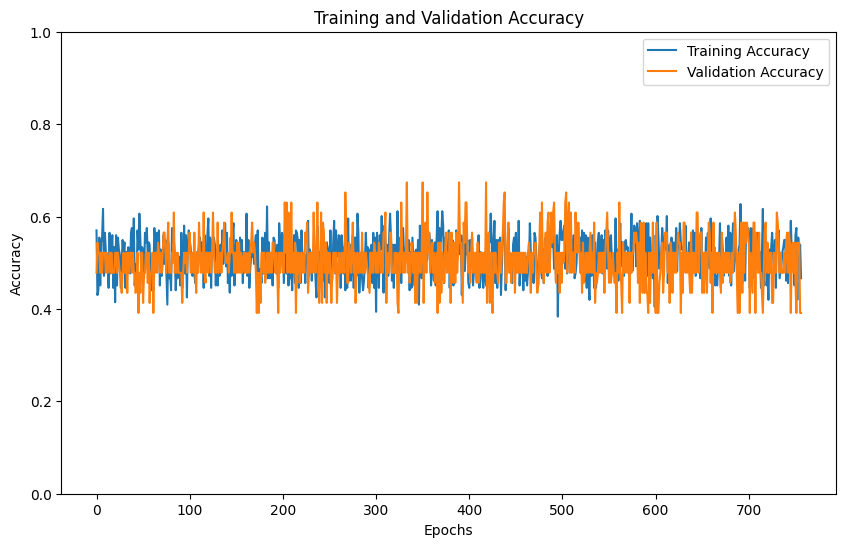

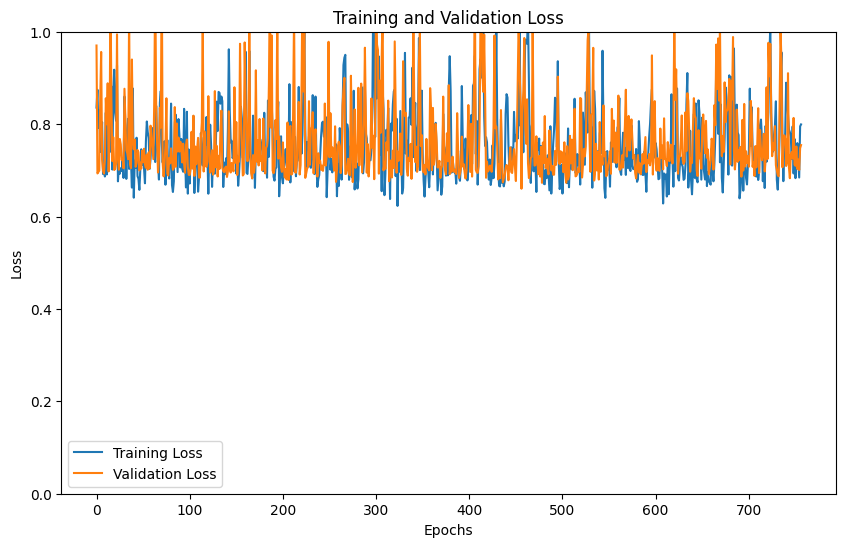

In [10]:
train_model('ResNet101', 'Adam')

#### **SGD Optimizer**

Epoch 1/1000


c:\Users\alema\Desktop\paper\nodulos_tiroideos\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 35s 3s/step - accuracy: 0.5218 - loss: 0.8479 - val_accuracy: 0.4783 - val_loss: 0.8715
Epoch 2/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.4906 - loss: 0.8278 - val_accuracy: 0.4783 - val_loss: 0.9232
Epoch 3/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.5132 - loss: 0.8951 - val_accuracy: 0.5217 - val_loss: 0.7043
Epoch 4/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.5572 - loss: 0.8000 - val_accuracy: 0.4783 - val_loss: 0.7456
Epoch 5/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.4634 - loss: 0.8515 - val_accuracy: 0.5217 - val_loss: 0.6827
Epoch 6/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.4615 - loss: 0.7493 - val_accuracy: 0.4783 - val_loss: 0.7403
Epoch 7/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.4351 - loss: 1.0350 - val_accuracy: 0.4783 - val_loss: 0.8043
Epoch 8/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.3997 - loss: 0.8461 - val_accuracy: 0.4783 - val_loss: 0.7400
Epoch

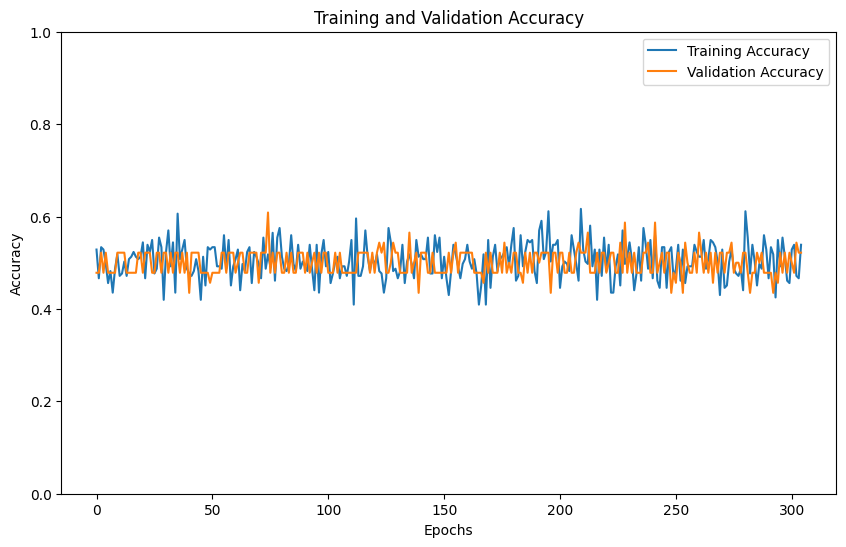

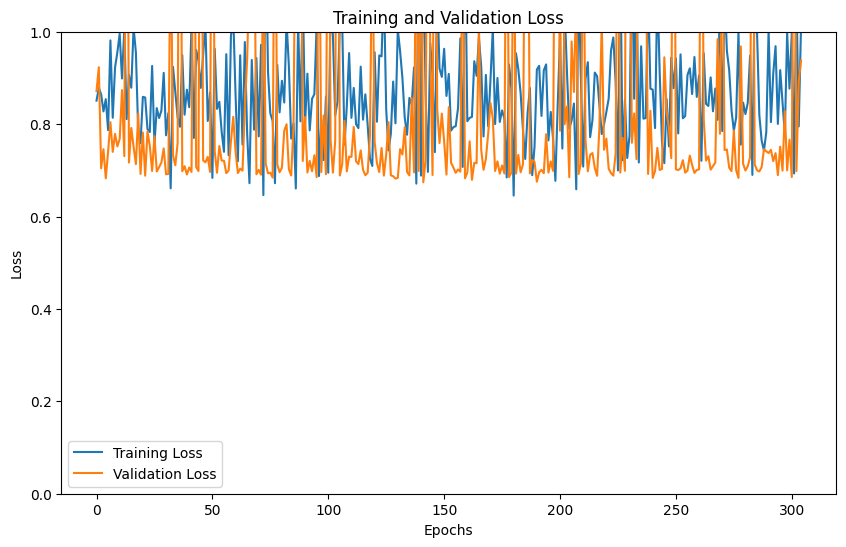

In [11]:
train_model('ResNet101', 'SGD')

## **VGG**

### **VGG16**

#### **Adam Optimizer**

In [ ]:
train_model('VGG16', 'Adam')

Epoch 1/1000


c:\Users\alema\Desktop\paper\nodulos_tiroideos\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 30s 4s/step - accuracy: 0.4789 - loss: 0.7254 - val_accuracy: 0.5000 - val_loss: 0.6965
Epoch 2/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 30s 5s/step - accuracy: 0.6025 - loss: 0.6673 - val_accuracy: 0.5217 - val_loss: 0.7222
Epoch 3/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 29s 4s/step - accuracy: 0.5686 - loss: 0.7097 - val_accuracy: 0.4783 - val_loss: 0.7528
Epoch 4/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 30s 5s/step - accuracy: 0.5498 - loss: 0.6801 - val_accuracy: 0.4783 - val_loss: 0.7955
Epoch 5/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 29s 4s/step - accuracy: 0.4547 - loss: 0.7145 - val_accuracy: 0.5217 - val_loss: 0.7848
Epoch 6/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 29s 4s/step - accuracy: 0.5373 - loss: 0.9680 - val_accuracy: 0.4348 - val_loss: 0.7113
Epoch 7/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 30s 4s/step - accuracy: 0.4721 - loss: 0.7069 - val_accuracy: 0.4783 - val_loss: 0.8644
Epoch 8/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 29s 4s/step - accuracy: 0.4173 - loss: 0.8288 - val_accuracy: 0.5217 - val_loss: 0.6949
Epoch

KeyboardInterrupt: 

#### **SGD Optimizer**

In [ ]:
train_model('VGG16', 'SGD')

### **VGG19**

#### **Adam Optimizer**

In [19]:
train_model('VGG19', 'Adam')

Epoch 1/1000


c:\Users\alema\Desktop\paper\nodulos_tiroideos\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 33s 5s/step - accuracy: 0.4858 - loss: 0.7412 - val_accuracy: 0.5435 - val_loss: 0.6920
Epoch 2/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 38s 5s/step - accuracy: 0.4916 - loss: 0.6870 - val_accuracy: 0.4783 - val_loss: 0.8440
Epoch 3/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 38s 6s/step - accuracy: 0.5167 - loss: 0.6623 - val_accuracy: 0.5000 - val_loss: 0.7021
Epoch 4/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 34s 5s/step - accuracy: 0.5001 - loss: 0.7116 - val_accuracy: 0.5217 - val_loss: 0.8216
Epoch 5/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 34s 5s/step - accuracy: 0.5477 - loss: 0.7606 - val_accuracy: 0.4565 - val_loss: 0.7026
Epoch 6/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 37s 6s/step - accuracy: 0.6001 - loss: 0.6667 - val_accuracy: 0.5217 - val_loss: 0.7056
Epoch 7/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 37s 5s/step - accuracy: 0.4873 - loss: 0.7459 - val_accuracy: 0.4783 - val_loss: 0.7686
Epoch 8/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 38s 5s/step - accuracy: 0.4831 - loss: 0.7180 - val_accuracy: 0.5000 - val_loss: 0.7022
Epoch

#### **SDG Optimizer**

In [ ]:
train_model('VGG19', 'SGD')

## **Xception**

### **Adam**

Epoch 1/1000


c:\Users\alema\Desktop\paper\nodulos_tiroideos\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.5079 - loss: 0.9979 - val_accuracy: 0.4783 - val_loss: 0.8049
Epoch 2/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.5512 - loss: 0.6733 - val_accuracy: 0.5217 - val_loss: 0.8134
Epoch 3/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.5481 - loss: 0.7872 - val_accuracy: 0.4783 - val_loss: 0.7538
Epoch 4/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.5096 - loss: 0.7317 - val_accuracy: 0.5217 - val_loss: 0.8037
Epoch 5/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 33s 4s/step - accuracy: 0.5952 - loss: 0.6701 - val_accuracy: 0.5000 - val_loss: 0.8225
Epoch 6/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 31s 4s/step - accuracy: 0.4567 - loss: 0.8905 - val_accuracy: 0.4783 - val_loss: 0.8687
Epoch 7/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 31s 4s/step - accuracy: 0.5253 - loss: 0.7505 - val_accuracy: 0.5217 - val_loss: 1.0332
Epoch 8/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 30s 4s/step - accuracy: 0.5768 - loss: 0.8616 - val_accuracy: 0.4130 - val_loss: 0.8674
Epoch

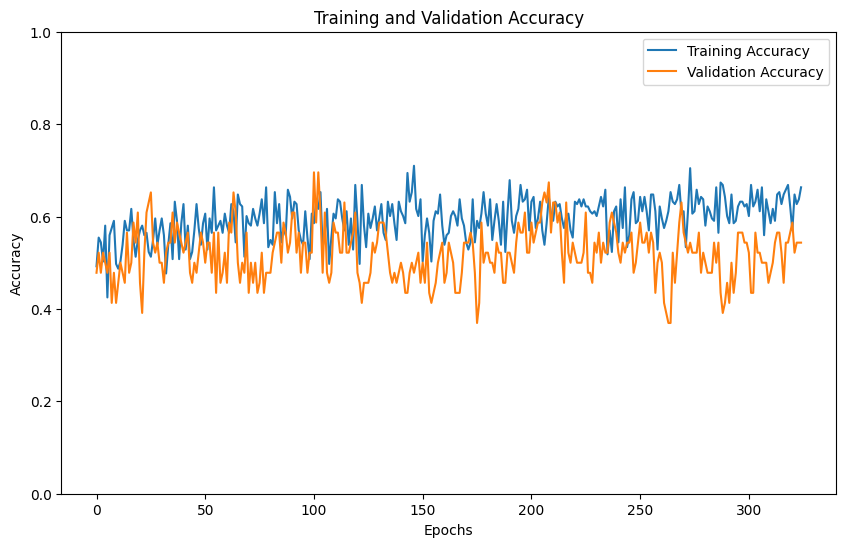

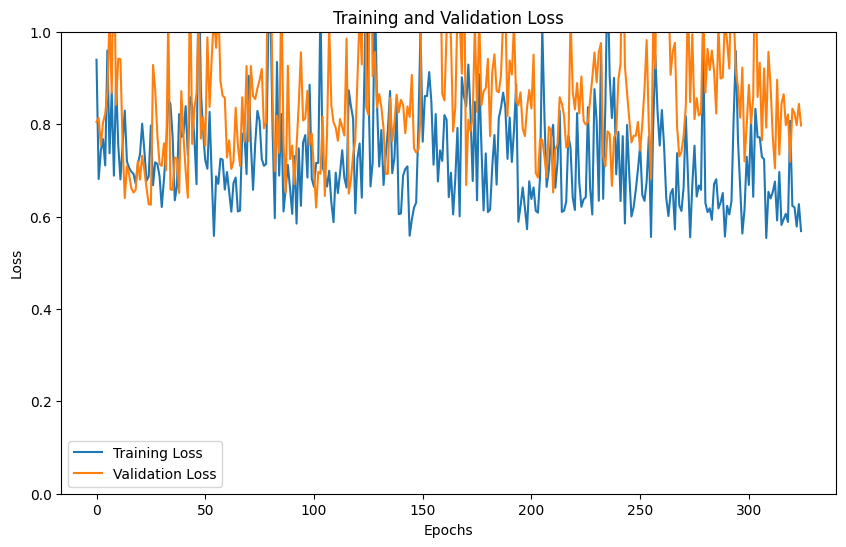

In [18]:
train_model('Xception', 'Adam')

### **SGD**

Epoch 1/1000


c:\Users\alema\Desktop\paper\nodulos_tiroideos\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.4363 - loss: 0.6929 - val_accuracy: 0.4348 - val_loss: 0.7524
Epoch 2/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.4951 - loss: 0.7142 - val_accuracy: 0.4130 - val_loss: 0.7034
Epoch 3/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.4525 - loss: 0.7077 - val_accuracy: 0.4565 - val_loss: 0.7158
Epoch 4/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.4140 - loss: 0.7348 - val_accuracy: 0.4565 - val_loss: 0.7434
Epoch 5/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.4923 - loss: 0.7144 - val_accuracy: 0.3913 - val_loss: 0.7242
Epoch 6/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.4896 - loss: 0.7050 - val_accuracy: 0.3696 - val_loss: 0.7095
Epoch 7/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.6027 - loss: 0.6880 - val_accuracy: 0.5217 - val_loss: 0.7261
Epoch 8/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.4917 - loss: 0.6901 - val_accuracy: 0.5000 - val_loss: 0.7243
Epoch

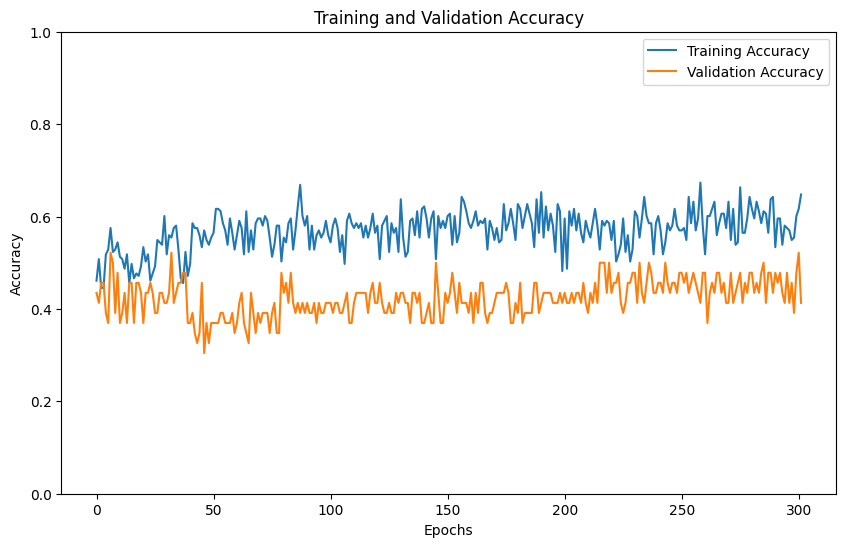

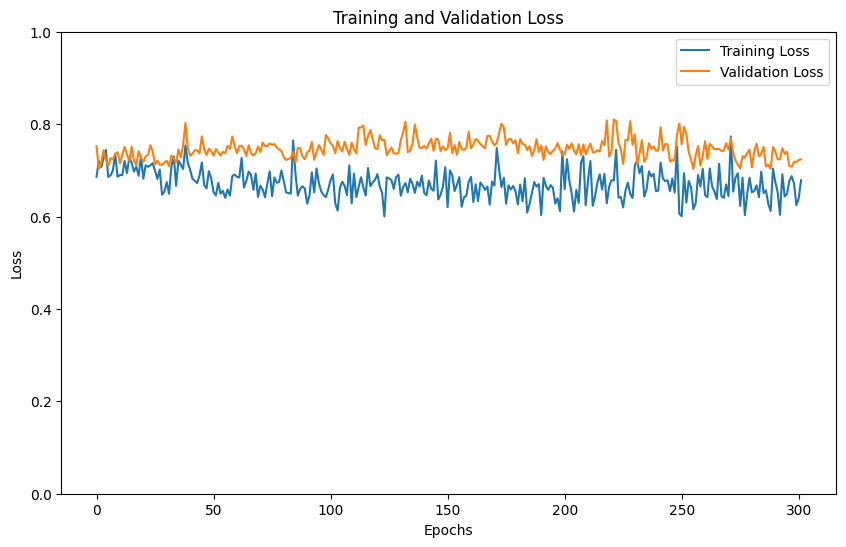

In [15]:
train_model('Xception', 'SGD')

## **DenseNet**

### **Adam**

Epoch 1/1000


c:\Users\alema\Desktop\paper\nodulos_tiroideos\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.5123 - loss: 0.7834 - val_accuracy: 0.5217 - val_loss: 0.7472
Epoch 2/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.5174 - loss: 0.8070 - val_accuracy: 0.4348 - val_loss: 0.7191
Epoch 3/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.4351 - loss: 0.8630 - val_accuracy: 0.5217 - val_loss: 1.0152
Epoch 4/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - accuracy: 0.4086 - loss: 1.0509 - val_accuracy: 0.4783 - val_loss: 0.9269
Epoch 5/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.4490 - loss: 0.8560 - val_accuracy: 0.5000 - val_loss: 0.8756
Epoch 6/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.3924 - loss: 1.1282 - val_accuracy: 0.4783 - val_loss: 1.0071
Epoch 7/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.4422 - loss: 0.7913 - val_accuracy: 0.5217 - val_loss: 0.8289
Epoch 8/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.5848 - loss: 0.6344 - val_accuracy: 0.4783 - val_loss: 0.7251
Epoch

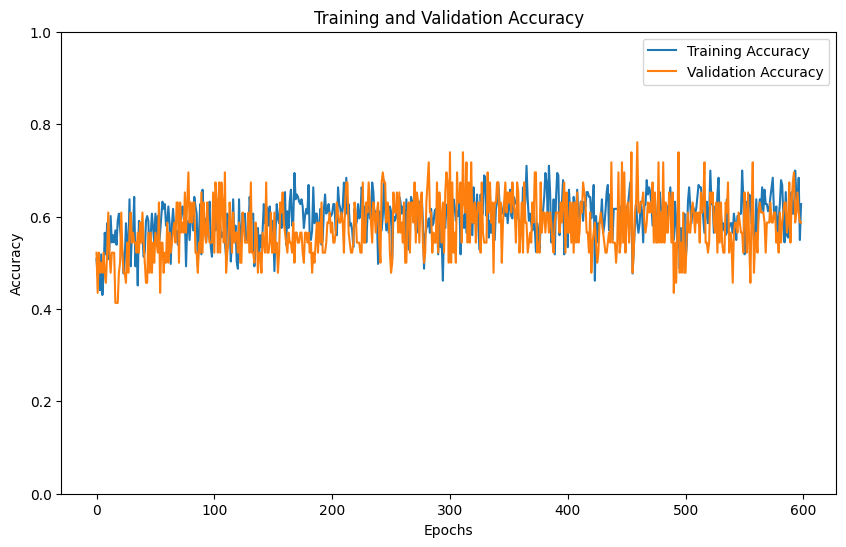

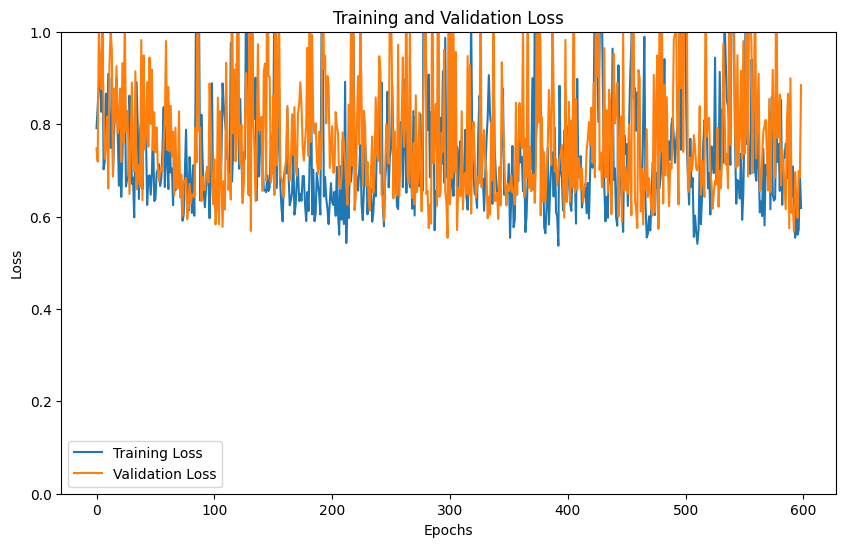

In [13]:
train_model('DenseNet', 'Adam')

### **SGD**

Epoch 1/1000


c:\Users\alema\Desktop\paper\nodulos_tiroideos\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.5423 - loss: 0.6706 - val_accuracy: 0.6087 - val_loss: 0.6727
Epoch 2/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.5077 - loss: 0.7138 - val_accuracy: 0.4783 - val_loss: 0.8938
Epoch 3/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.4457 - loss: 0.8291 - val_accuracy: 0.5435 - val_loss: 0.6715
Epoch 4/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.5292 - loss: 0.6789 - val_accuracy: 0.5000 - val_loss: 0.7167
Epoch 5/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.5437 - loss: 0.7783 - val_accuracy: 0.5652 - val_loss: 0.6410
Epoch 6/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.5393 - loss: 0.7044 - val_accuracy: 0.5652 - val_loss: 0.6575
Epoch 7/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.5441 - loss: 0.7088 - val_accuracy: 0.4783 - val_loss: 0.7368
Epoch 8/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.4637 - loss: 0.9707 - val_accuracy: 0.5217 - val_loss: 0.6879
Epoch

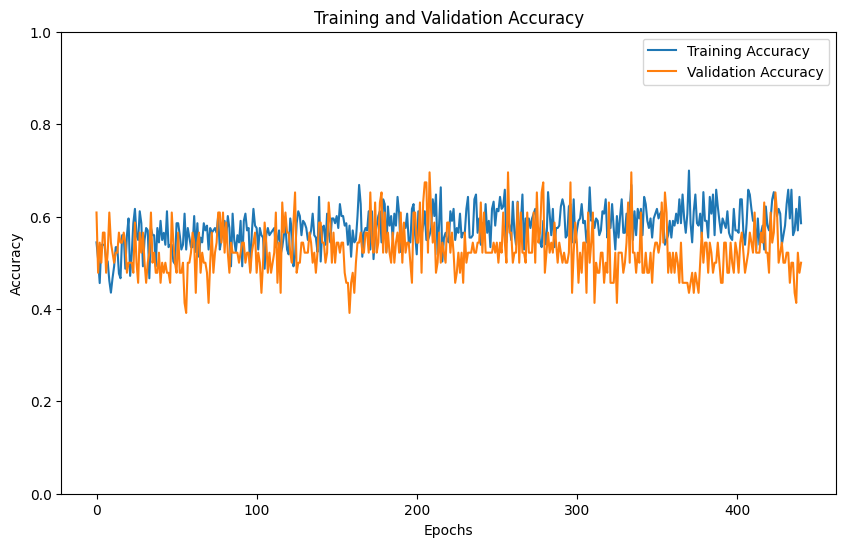

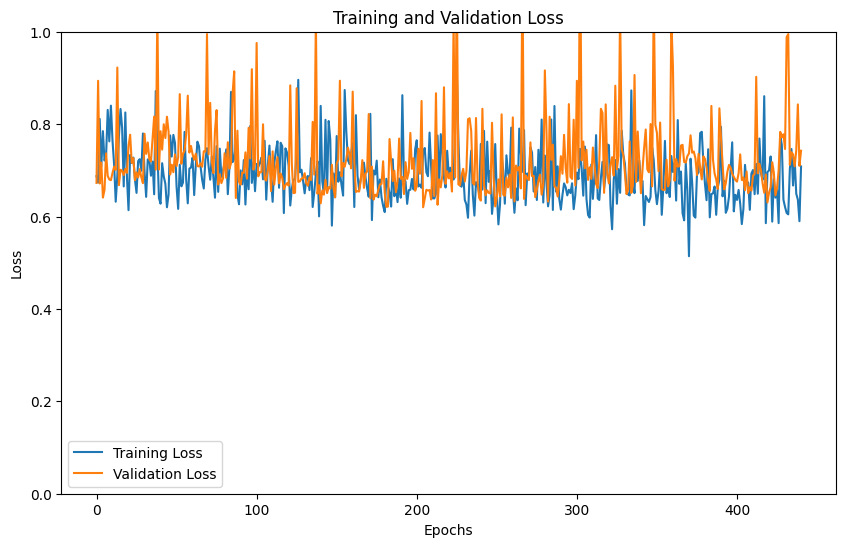

In [14]:
train_model('DenseNet', 'SGD')